## Import modules

In [1]:
# fundamentals
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.feature_selection import SelectPercentile

# pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

# Evaluation, optimization, metrics
from sklearn.metrics import recall_score, precision_score, precision_recall_curve, f1_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.inspection import permutation_importance

# model
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

## Prepare graphics

In [2]:
def plot_roc(pipe, Xtest, ytest):
    yscores = pipe.predict_proba(Xtest)[:,1]
    fpr, tpr, _ = roc_curve(ytest, yscores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')

## Load, clean and split the data

In [3]:
raw_data = pd.read_csv("Data/HR_Analytics.csv")

In [16]:
# Assign columns to column groups
catcols = ["AgeGroup", "SalarySlab", "Department", "EducationField", "JobRole", "MaritalStatus"]
numcols = ["EnvironmentSatisfaction", "BusinessTravel", "JobInvolvement", "JobLevel", "JobSatisfaction", 
           "RelationshipSatisfaction", "StockOptionLevel", "WorkLifeBalance", "OverTime", "Age", "DailyRate", "DistanceFromHome", 
           "MonthlyIncome", "NumCompaniesWorked", "PercentSalaryHike", "TotalWorkingYears", 
           "TrainingTimesLastYear", "YearsAtCompany", "YearsInCurrentRole", "YearsWithCurrManager", "GotPromoted"]
delcols = ["MonthlyRate", "HourlyRate", "Education", "EmpID", "EmployeeCount", "EmployeeNumber", "StandardHours", "Over18", "PerformanceRating", "Gender", "YearsSinceLastPromotion"]

gotpromoted = []
for emp in raw_data.index:
    if raw_data.loc[emp,"YearsSinceLastPromotion"] < raw_data.loc[emp,"YearsAtCompany"]:
        gotpromoted.append(1)
    else:
        gotpromoted.append(0)
raw_data.loc[:,"GotPromoted"] = gotpromoted

# clean data
def clean_data(DF, delcols=delcols):
    df = DF.drop_duplicates()
    df = df.drop(delcols, axis=1)
    df = df.replace({"Yes": 1,
                     "No": 0,
                     "Female": 1,
                     "Male": 0,
                     "Non-Travel": 0,
                     "TravelRarely": 1,
                     "Travel_Rarely": 1,
                     "Travel_Frequently": 2})
    #df = df.dropna(axis=0)
    return df

data = clean_data(raw_data)

Xtrain, Xtest, ytrain, ytest = train_test_split(data.drop("Attrition", axis=1), 
                                                data["Attrition"], 
                                                test_size=0.2, 
                                                shuffle=True,
                                                stratify=data["Attrition"], 
                                                random_state=13)

In [17]:
Xtrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1178 entries, 1059 to 262
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       1178 non-null   int64  
 1   AgeGroup                  1178 non-null   object 
 2   BusinessTravel            1178 non-null   int64  
 3   DailyRate                 1178 non-null   int64  
 4   Department                1178 non-null   object 
 5   DistanceFromHome          1178 non-null   int64  
 6   EducationField            1178 non-null   object 
 7   EnvironmentSatisfaction   1178 non-null   int64  
 8   JobInvolvement            1178 non-null   int64  
 9   JobLevel                  1178 non-null   int64  
 10  JobRole                   1178 non-null   object 
 11  JobSatisfaction           1178 non-null   int64  
 12  MaritalStatus             1178 non-null   object 
 13  MonthlyIncome             1178 non-null   int64  
 14  Salary

## Prepare preprocessing

In [18]:
encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
simpimp = SimpleImputer(strategy="median")
std = StandardScaler()

catpipe = make_pipeline(encoder)
numpipe = Pipeline([("imputer", simpimp),
                    ("scaler", std)])

coltrans = ColumnTransformer(transformers=[("encoder", encoder, catcols),
                                           ("numpipe", numpipe, numcols)])
selection = SelectPercentile(percentile=80) # percentile=10

## Initialize estimator

In [19]:
model = XGBClassifier(objective='binary:logistic', 
                      n_estimators=150,            # Number of boosting rounds
                      learning_rate=0.1,         # Step size shrinkage
                      max_depth=15,                    # Maximum depth of the tree
                      min_child_weight=5,             # Minimum sum of instance weight in a child
                      subsample=0.8,                   # Subsample ratio of the training instances
                      colsample_bytree=1.0,            # Subsample ratio of columns when constructing each tree
                      gamma=0,                    # Minimum loss reduction required for further partition
                      reg_alpha=0,                # L1 regularization term on weights
                      reg_lambda=0.2,
                      random_state=42)

## Set search space

In [20]:
search_space = {#"estimator__n_estimators": [50, 100, 150],            # Number of boosting rounds
                #"estimator__learning_rate": [0.1, 0.2, 0.3],         # Step size shrinkage
                #"estimator__max_depth": [12, 15, 18],                    # Maximum depth of the tree
                #"estimator__min_child_weight": [1, 3, 5],             # Minimum sum of instance weight in a child
                #"estimator__subsample": [0.8, 1.0],                   # Subsample ratio of the training instances
                #"estimator__colsample_bytree": [0.8, 1.0],            # Subsample ratio of columns when constructing each tree
                #"estimator__gamma": [0, 0.1, 0.2, 0.3],                    # Minimum loss reduction required for further partition
                #"estimator__reg_alpha": [0, 0.1, 0.2],                # L1 regularization term on weights
                #"estimator__reg_lambda": [0, 0.1, 0.2],
                #"selector__percentile": [80, 85]
               }

## Finish pipeline and run grid search

Fitting 5 folds for each of 1 candidates, totalling 5 fits
{}
Best F1 score: 44.81%
--------------------------------------------------------
F1 score on test set:	62.16%
Recall on test set:	48.94%
Precision on test set:	85.19%


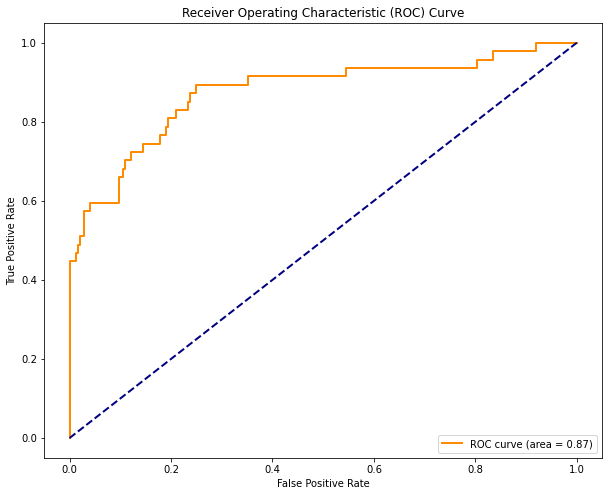

In [21]:
pipeline = Pipeline([("prepper", coltrans),
                     #("selector", selection),
                     ("estimator", model)])

pipe = GridSearchCV(estimator=pipeline,
                    param_grid=search_space,
                    scoring="f1",
                    cv=5,
                    verbose=3, 
                    n_jobs=-1)
pipe.fit(Xtrain, ytrain)
#model_svc = pipe_svc.best_estimator_
#print(grid_svc.best_estimator_)
print(pipe.best_params_)
print(f"Best F1 score: {pipe.best_score_.mean():.2%}")
print("--------------------------------------------------------")
ypred = pipe.predict(Xtest)
print(f"F1 score on test set:\t{f1_score(ytest, ypred):.2%}")
print(f"Recall on test set:\t{recall_score(ytest, ypred):.2%}")
print(f"Precision on test set:\t{precision_score(ytest, ypred):.2%}")
plot_roc(pipe, Xtest, ytest)

In [22]:
results = pd.DataFrame(pipe.cv_results_).sort_values(by="mean_test_score", ascending=False).head(9)
results.iloc[:,4:]

,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,{},0.580645,0.37037,0.5,0.539683,0.25,0.44814,0.121602,1


# Result:
The best LogisticRegression model we've found achieved...  
...an F1 score of 54.67%  
...a ROC-AUC score of 90%  
on the test set.

[Text(0.5, 1.0, 'Features sorted by permutation importance'),
 Text(0.5, 0, 'Permutation Importance')]

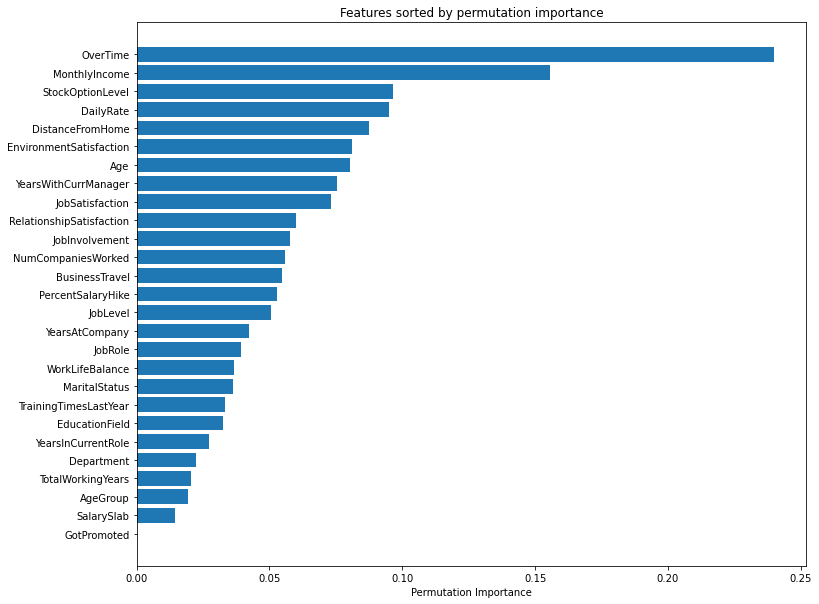

In [23]:
# Estimate feature importance through permutation importance
result = permutation_importance(pipe, Xtrain, ytrain, n_repeats=50, random_state=42)
importance_scores = abs(result.importances_mean)
#pipe_rfc = pipe_rfc.fit(features_train, target_train)
original_columns = Xtrain.columns
feature_importance_list = list(zip(original_columns, importance_scores))
sorted_feature_importance = sorted(feature_importance_list, key=lambda x: x[1], reverse=False)
orig_sorted_features, orig_sorted_importance = zip(*sorted_feature_importance)

# Plot it
fig, ax = plt.subplots(figsize=(12,10))
ax.barh(orig_sorted_features, orig_sorted_importance)
ax.set(title="Features sorted by permutation importance",
      xlabel="Permutation Importance")